Liquidity (depth, spread, volatility) vs quote currency - Steven
- 1m return volatility.
- Depth proxies (volume / RV, inverse Amihud).
- Spread proxies (Roll covariance or, if you later get quotes, quoted/effective spreads). Roll model for spreads
- Compare BTC/USD vs BTC/USDT vs BTC/USDC and highlight systematic differences.
 

**Goals:**
- realized vol
- effective spread
- realized spread
- price impact
- trade-level
- Kyle's lambda
- order flow imbalance

In [2]:
# all imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm

sns.set_theme(style="darkgrid")
pd.set_option("display.precision", 4)
REGIME_ORDER = ["calm", "stress", "post"]

## Load Data
**Regimes (UTC, by date):**
- calm: date ≤ 2023-03-09
- stress: 2023-03-10 to 2023-03-14
- post: date ≥ 2023-03-15

In [3]:
bnus_spot_btc_usd = '../Data/ohlcv_1s_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
bnus_spot_btc_usdc = '../Data/ohlcv_1s_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
bnus_spot_btc_usdt = '../Data/ohlcv_1s_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

cbse_spot_btc_usd = '../Data/ohlcv_1s_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
cbse_spot_btc_usdt = '../Data/ohlcv_1s_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

trades_bnus_btc_usd = '../Data/trades_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
trades_bnus_btc_usdc = '../Data/trades_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
trades_bnus_btc_usdt = '../Data/trades_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

trades_cbse_btc_usd = '../Data/trades_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
trades_cbse_btc_usdt = '../Data/trades_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

trade_files = [
    {'exchange':'binance', 'pair':'BTC/USD', 'ohlc_path': bnus_spot_btc_usd, 'trade_path': trades_bnus_btc_usd},
    {'exchange':'binance', 'pair':'BTC/USDC', 'ohlc_path': bnus_spot_btc_usdc, 'trade_path': trades_bnus_btc_usdc},
    {'exchange':'binance', 'pair':'BTC/USDT', 'ohlc_path': bnus_spot_btc_usdt, 'trade_path': trades_bnus_btc_usdt},
    
    {'exchange':'coinbase', 'pair':'BTC/USD', 'ohlc_path': cbse_spot_btc_usd, 'trade_path': trades_cbse_btc_usd},
    {'exchange':'coinbase', 'pair':'BTC/USDT', 'ohlc_path': cbse_spot_btc_usdt, 'trade_path': trades_cbse_btc_usdt},
]

## Format 1 Minute Framework

I chose to analyze via a 1 minute because there are many missing 1s timestamps and I dont want to spend too long cleaning gaps etc. This way micro noise's effect is reduced. 1s intervals are not needed in regime comparison as well.

### Depth Proxies: *How much trading can happen without moving the price much?*
- [**Amihud Illiquidity**](https://ba-odegaard.no/teach/notes/liquidity_estimators/amihud_estimator/amihud_lectures.pdf): trade/return-based proxy for price impact
    - *How much does price move per dollar traded?*
    - higher value => worse liquidty

- [**Kyle's Lambda**](https://haas.berkeley.edu/wp-content/uploads/StocLiq21.pdf): estimates the slope of price response to a signed order flow
    - *How much does price move for a given net aggressive buy/sell flow?*
    - higher value => lower liquidity (given trade volume causes a larger price impact)
    
### Spread Proxies: *How much 
- **Roll Spread**: estimates the effective spread from bid-ask bounce
    - higher value => wider spreads => worse execution costs
    
https://pressacademia.org/archives/jefa/v3/i3/7.pdf

In [147]:
# def hl_from_ohlc(ohlc_bar):
#     denom = ohlc_bar['close'].replace(0, np.nan)
    
#     s = 1e4 * (ohlc_bar['high'] - ohlc_bar['low']) / denom
#     s = s.replace([np.inf, -np.inf], np.nan)
#     s.name = 'hl_bps'
    
#     return s


# def hl_by_regime_from_ohlc(ohlc_1s, bar='1min', agg='median'):
#     bars = resample_ohlc(ohlc_1s, bar=bar)
    
#     bars['hl_bps'] = hl_from_ohlc(bars)

#     if agg == 'mean':
#         out = bars.groupby('regime', sort=False)['hl_bps'].mean()
#     else:
#         out = bars.groupby('regime', sort=False)['hl_bps'].median()

#     out.name = f'hl_bps_{agg}'
    
#     return out.reindex(REGIME_ORDER)


# def cs_from_ohlc(ohlc_bar, clip_alpha=False, min_bps=0.1):
#     H = ohlc_bar['high']
#     L = ohlc_bar['low']

#     H1, L1 = H.shift(1), L.shift(1)
#     H2, L2 = H, L

#     r1 = np.log(H1 / L1)
#     r2 = np.log(H2 / L2)

#     beta = (r1 ** 2) + (r2 ** 2)

#     Hmax = np.maximum(H1, H2)
#     Lmin = np.minimum(L1, L2)
#     gamma = (np.log(Hmax / Lmin)) ** 2

#     k = 3.0 - 2.0 * np.sqrt(2.0)

#     alpha = (np.sqrt(2.0 * beta) - np.sqrt(beta)) / k - np.sqrt(gamma / k)
#     alpha = alpha.replace([np.inf, -np.inf], np.nan)

#     if clip_alpha:
#         alpha = alpha.clip(lower=0)
#     else:
#         alpha = alpha.where(alpha > 0, np.nan)

#     S = 2.0 * (np.exp(alpha) - 1.0) / (1.0 + np.exp(alpha))
#     S = S.replace([np.inf, -np.inf], np.nan)

#     cs_bps = 1e4 * S
#     cs_bps.name = 'cs_spread_bps'

#     if min_bps is not None and min_bps > 0:
#         cs_bps = cs_bps.where(cs_bps > min_bps, np.nan)

#     return cs_bps


# def cs_by_regime_from_ohlc(ohlc_1s, bar='1min', agg='median'):
#     bars = resample_ohlc(ohlc_1s, bar=bar)
    
#     cs = cs_from_ohlc(bars, clip_alpha=False, min_bps=0.0)
#     tmp = pd.DataFrame({'cs_spread_bps': cs}).dropna()
#     tmp = add_regime_labels(tmp)

#     if agg == 'mean':
#         out = tmp.groupby('regime', sort=False)['cs_spread_bps'].mean()
#     else:
#         out = tmp.groupby('regime', sort=False)['cs_spread_bps'].median()

#     out.name = f'cs_spread_bps_{agg}'
    
#     return out.reindex(REGIME_ORDER)

In [153]:
# adds regime labels
def add_regime_labels(in_df):
    out_df = in_df.copy()
    d = out_df.index.normalize()

    out_df['regime'] = np.select(
        [d <= pd.Timestamp('2023-03-09', tz='UTC'), d <= pd.Timestamp('2023-03-14', tz='UTC')], 
        ['calm', 'stress'],
        default='post'
    )
    return out_df


# ensure proper ts index for ohlc df
def load_ohlc(path):
    ohlc = pd.read_csv(path)
    ohlc['ts'] = pd.to_datetime(ohlc['timestamp'], unit='ms', utc=True)
    ohlc = ohlc.sort_values('ts').set_index('ts')

    for c in ['open','high','low','close','volume']:
        ohlc[c] = pd.to_numeric(ohlc[c], errors='coerce')

    ohlc = ohlc.dropna(subset=['close'])
    ohlc = ohlc[ohlc['volume'] > 0]
    ohlc = add_regime_labels(ohlc)
    
    return ohlc


# ensure proper ts index for trades df
def load_trades_ohlc(trades_path, ohlc_path):
    ohlc = load_ohlc(ohlc_path)
    
    trades = pd.read_csv(trades_path)
    trades['ts'] = pd.to_datetime(trades['timestamp'], unit='ms', utc=True)
    trades = trades.sort_values('ts').set_index('ts')
    
    trades = add_regime_labels(trades)
    trades = pd.merge_asof(
        trades,
        ohlc[['close']],
        left_index=True,
        right_index=True,
        direction='backward'
    )
    
    return trades, ohlc

# resample ohlc bars
def resample_ohlc(ohlc_df, bar='1min'):
    g = ohlc_df.resample(bar)
    
    out = pd.DataFrame({
        'open': g['open'].first(),
        'high': g['high'].max(),
        'low':  g['low'].min(),
        'close':g['close'].last(),
        'volume': g['volume'].sum(),
    }).dropna(subset=['close','high','low'])
    
    out = out[out['volume'] > 0]
    out = add_regime_labels(out)
    
    return out


# format trades to 1m 
def resample_trades(trades_df, freq='1min'):
    df = trades_df.copy()

    df['dollar'] = df['price'] * df['amount']
    df['sign'] = np.where(df['taker_side_sell'].astype(bool), -1.0, +1.0)
    df['signed_dollar'] = df['sign'] * df['dollar']

    # vwap
    vwap_1m = df['dollar'].resample('1min').sum() / df['amount'].resample('1min').sum()

    out = pd.DataFrame({
        'vwap': vwap_1m,
        'last': df['price'].resample('1min').last(),
        'vol_dollar': df['dollar'].resample('1min').sum(),
        'n_trades': df['price'].resample('1min').count(),
        'signed_dollar': df['signed_dollar'].resample('1min').sum(),
    })

    out['ret'] = np.log(out['vwap']).diff()
    out['rv_1m'] = out['ret']**2
    out['amihud_1m'] = out['ret'].abs() / out['vol_dollar'].replace(0, np.nan)
    
    out = add_regime_labels(out)
    out = out.dropna(subset=['vwap', 'ret', 'vol_dollar'])
    
    return out 


def ohlc_from_trades(trades, bar="1min"):
    g = trades.resample(bar)
    out = pd.DataFrame({
        "open":  g["price"].first(),
        "high":  g["price"].max(),
        "low":   g["price"].min(),
        "close": g["price"].last(),
        "volume": g["amount"].sum(),
        "n_trades": g["price"].count(),
    })
    out = out.dropna(subset=["open", "high", "low", "close"])
    out = out[out["n_trades"] > 0]
    return add_regime_labels(out)

In [154]:
# calc kyle lambda
def kyle_lambda_by_regime(trades_1m):
    df = trades_1m.copy()

    def fit_lambda(df):
        df = df[['ret', 'signed_dollar']].dropna()
        y = df['ret'].to_numpy()
        x = df['signed_dollar'].to_numpy()
        
        X = np.column_stack([np.ones_like(x), x])
        a, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        
        return float(a[1]) * 1000000.0

    kyle = df.groupby('regime', sort=False).apply(fit_lambda)
    kyle.name = 'lambda'
    
    return kyle

In [171]:
def roll_from_trades(trades_df):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    r = np.log(P).diff().dropna()
    roll_cov = np.cov(r[1:], r[:-1])[0,1]
    
    if pd.isna(roll_cov) or roll_cov >= 0: return np.nan
    
    roll_spread = 2 * np.sqrt(-roll_cov)
    roll_spread_bps = roll_spread * 10_000

    return roll_spread_bps

def roll_by_regime_from_trades(trades_df):       
    rs = trades_df.groupby("regime", sort=False).apply(lambda g: roll_from_trades(g))
    rs.name = "roll_spread"
    
    return rs.reindex(REGIME_ORDER)

In [185]:
def es_from_trades(trades_df, agg='mean'):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    mid = g['close'].astype(float)
    
    exp_spread = 2 * side * (P - mid)
    exp_spread_bps = (exp_spread / P) * 10000
    
    if agg == 'mean':
        return exp_spread_bps.mean()
    else: 
        return exp_spread_bps.median()
    
def es_by_regime_from_trades(trades_df,  agg='mean'):
    es = trades_df.groupby("regime", sort=False).apply(lambda g: es_from_trades(g, agg=agg))
    es.name = "expected_spread"

    return es.reindex(REGIME_ORDER)

In [186]:
def rs_from_trades(trades_df, agg='mean'):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    mid = g['close'].astype(float)
    
    future_mid = mid.shift(-5)
    
    realized_spread = 2 * side * (P - future_mid)
    realized_spread_bps = (realized_spread / P) * 10000
    
    if agg == 'mean':
        return realized_spread_bps.mean()
    else: 
        return realized_spread_bps.median()    

def rs_by_regime_from_trades(trades_df, agg='mean'):
    rs = trades_df.groupby("regime", sort=False).apply(lambda g: rs_from_trades(g, agg=agg))
    rs.name = "realized_spread"

    return rs.reindex(REGIME_ORDER)

In [182]:
# generate analysis summary value table
def summarize_liquidity(trades_df, roll_series, kyle_series, es_series, rs_series):
    
    def summ(g):
        nobs = len(g)
        n_trades = g['n_trades'].sum()
        vol_dollar = g['vol_dollar'].sum()
        rv_sum = g['rv_1m'].sum()
        rv_mean = g['rv_1m'].mean()
        sigma_ann = np.sqrt(rv_mean) * np.sqrt(525600)

        amihud_mean = g['amihud_1m'].mean()
        amihud_median = g['amihud_1m'].median()

        return pd.Series({
            'nobs': nobs,
            'n_trades': n_trades,
            'vol_dollar': vol_dollar,
            'rv_sum': rv_sum,
            'rv_mean': rv_mean,
            'sigma_ann': sigma_ann,
            'amihud_mean': amihud_mean,
            'amihud_median': amihud_median,
            'depth_proxy_vol_over_rv': vol_dollar / rv_mean if rv_mean > 0 else np.nan,
            'inv_amihud_median': 1.0 / amihud_median if amihud_median > 0 else np.nan,
            'n_trades_per_min': n_trades / nobs if nobs > 0 else np.nan,
            'avg_trade_dollar': vol_dollar / n_trades if n_trades > 0 else np.nan,
        })
    
    summ_df = trades_df.groupby('regime', observed=True).apply(summ).reindex(REGIME_ORDER)
    
    if roll_series is not None:
        summ_df['roll_spread'] = roll_series.reindex(REGIME_ORDER).to_numpy()
    if kyle_series is not None:
        summ_df['kyle_lambda_scaled'] = np.abs(kyle_series.reindex(REGIME_ORDER).to_numpy())
    if es_series is not None:
        summ_df['es_spread'] = es_series.reindex(REGIME_ORDER).to_numpy()
    if rs_series is not None:
        summ_df['rs_spread'] = rs_series.reindex(REGIME_ORDER).to_numpy()
    
    return summ_df

# runs across all exchanges and types
def run_liquidity_block(trade_files, agg):
    rows = []
    for spec in trade_files:
        trades = load_trades_with_regime(spec['trade_path'])
        trades, ohlc = load_trades_ohlc(spec['trade_path'], spec['ohlc_path'])
        panel = resample_trades(trades)
        
        roll = roll_by_regime_from_trades(trades)
        kyle = kyle_lambda_by_regime(panel)
        es = es_by_regime_from_trades(trades, agg=agg)
        rs = rs_by_regime_from_trades(trades, agg=agg)

        summ = summarize_liquidity(panel, roll, kyle, es, rs)
        summ = summ.reset_index().rename(columns={'index': 'regime'})
        summ['exchange'] = spec['exchange']
        summ['pair'] = spec['pair']
        rows.append(summ)

    out = pd.concat(rows, ignore_index=True)
    out['regime'] = pd.Categorical(out['regime'], categories=REGIME_ORDER, ordered=True)
    out = out.sort_values(['exchange', 'pair', 'regime']).reset_index(drop=True)
    
    return out

# plot table for given metric
def plot_metric(all_summary, metric, title):
    piv = all_summary.pivot_table(index=['exchange', 'pair'], columns='regime', values=metric, aggfunc='mean')
    piv = piv.reindex(columns=REGIME_ORDER)
    ax = piv.plot(kind='bar', figsize=(10, 4))
    ax.set_title(title)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend(title='regime')

    plt.tight_layout()
    plt.show()

In [183]:
all_summary = run_liquidity_block(trade_files, agg='mean')
all_summary

,regime,nobs,n_trades,vol_dollar,rv_sum,rv_mean,sigma_ann,amihud_mean,amihud_median,depth_proxy_vol_over_rv,inv_amihud_median,n_trades_per_min,avg_trade_dollar,roll_spread,kyle_lambda_scaled,es_spread,rs_spread,exchange,pair
0,calm,12818.0,1010373.0,1.1282e+09,0.0033,2.5387e-07,0.3653,3.5856e-08,4.7147e-09,4.4438e+15,2.1210e+08,78.8245,1116.5874,0.9781,0.0027,2.2434e+08,2.2434e+08,binance,BTC/USD
1,stress,7198.0,1601108.0,1.3028e+09,0.0072,1.0030e-06,0.7261,1.2216e-08,4.1701e-09,1.2989e+15,2.3980e+08,222.4379,813.7027,1.8801,0.0034,2.2333e+08,2.2333e+08,binance,BTC/USD
2,post,10080.0,2823201.0,2.2948e+09,0.0073,7.2242e-07,0.6162,5.8539e-09,2.9690e-09,3.1765e+15,3.3681e+08,280.0795,812.8217,0.9257,0.0027,2.6581e+08,2.6581e+08,binance,BTC/USD
3,calm,4614.0,39506.0,2.9594e+07,0.0029,6.2668e-07,0.5739,1.1024e-06,1.1812e-07,4.7223e+13,8.4656e+06,8.5622,749.1046,0.8691,0.0278,2.2359e+08,2.2359e+08,binance,BTC/USDC
4,stress,3660.0,61338.0,2.4318e+07,0.0281,7.6747e-06,2.0084,7.4358e-06,2.6044e-07,3.1686e+12,3.8396e+06,16.7590,396.4553,17.2087,0.0591,2.2052e+08,2.2052e+08,binance,BTC/USDC
5,post,4332.0,33371.0,2.1680e+07,0.0058,1.3275e-06,0.8353,8.9795e-06,3.0270e-07,1.6331e+13,3.3036e+06,7.7034,649.6547,1.0464,0.0499,2.6548e+08,2.6548e+08,binance,BTC/USDC
6,calm,12069.0,418606.0,4.3146e+08,0.0033,2.7424e-07,0.3797,1.4314e-07,1.3253e-08,1.5733e+15,7.5456e+07,34.6844,1030.7044,1.1412,0.0066,2.2502e+08,2.2502e+08,binance,BTC/USDT
7,stress,7053.0,413888.0,5.8810e+08,0.0072,1.0268e-06,0.7346,1.8860e-07,9.2672e-09,5.7274e+14,1.0791e+08,58.6825,1420.9089,1.7904,0.0054,2.2070e+08,2.2070e+08,binance,BTC/USDT
8,post,9889.0,295484.0,4.2557e+08,0.0079,7.9995e-07,0.6484,6.6581e-07,2.0765e-08,5.3200e+14,4.8159e+07,29.8801,1440.2582,1.6640,0.0087,2.6378e+08,2.6378e+08,binance,BTC/USDT
9,calm,12674.0,2636263.0,2.3746e+09,0.0033,2.6266e-07,0.3716,6.1543e-09,1.8785e-09,9.0405e+15,5.3235e+08,208.0056,900.7499,0.4200,0.0012,2.2419e+08,2.2419e+08,coinbase,BTC/USD


## Volatility 
- Volatility is similar for USD vs USDT (same order of magnitude) on both exchanges
- USDC on Binance shows the depegging effects. Volatility went up to 20%

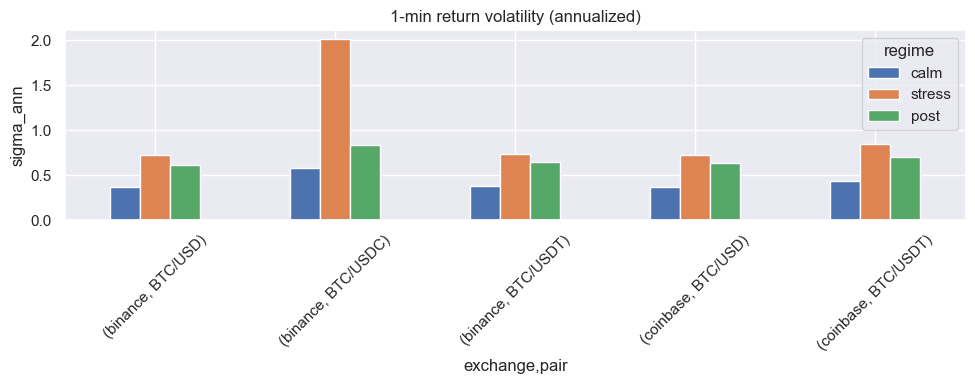

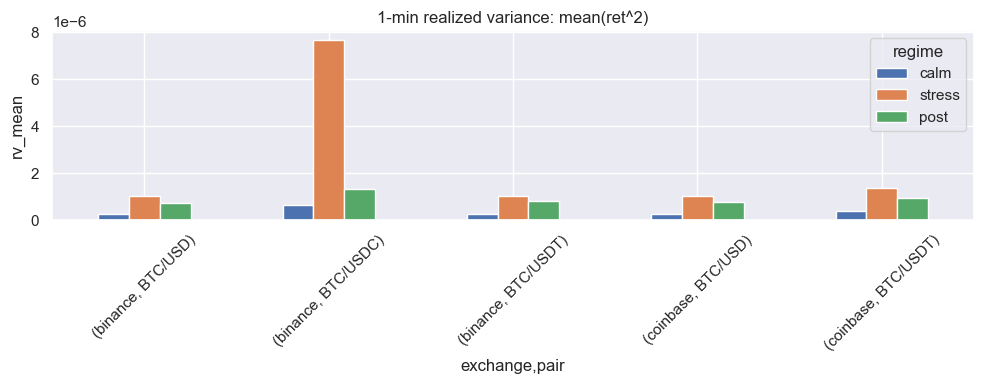

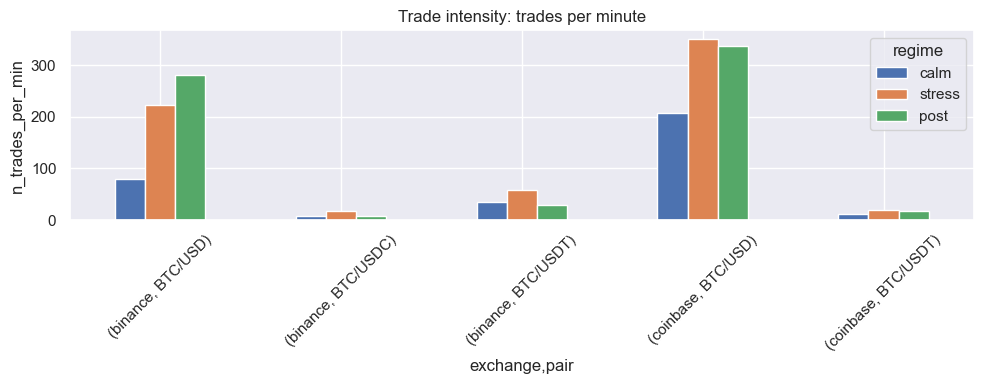

In [176]:
plot_metric(all_summary, 'sigma_ann', '1-min return volatility (annualized)')
plot_metric(all_summary, 'rv_mean', '1-min realized variance: mean(ret^2)')
plot_metric(all_summary, 'n_trades_per_min', 'Trade intensity: trades per minute')

## Depth
- Deeper liquidity = more size can be traded with less price impact
    - lower transaction costs (tigher spreads)
    - lower price impact (smaller Amihud, smaller Kyle)
    - more stable execution
- BTC/USD is consistently deeper / lower-impact than USDC/USDT
- USDC is dramatically worse than USDT

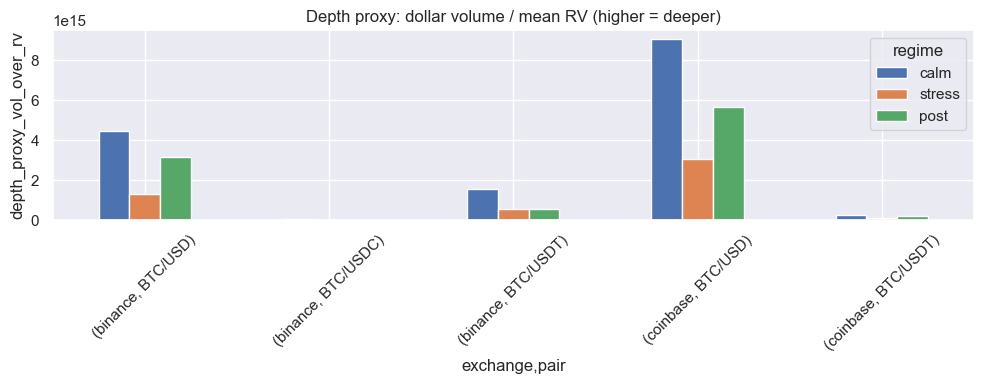

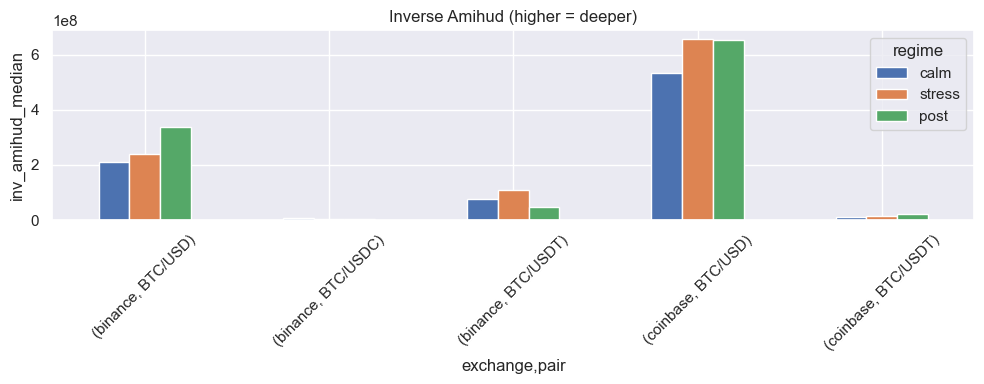

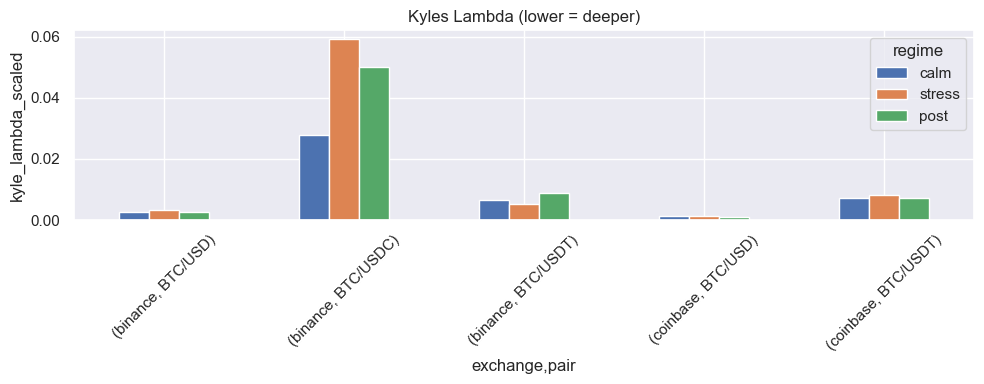

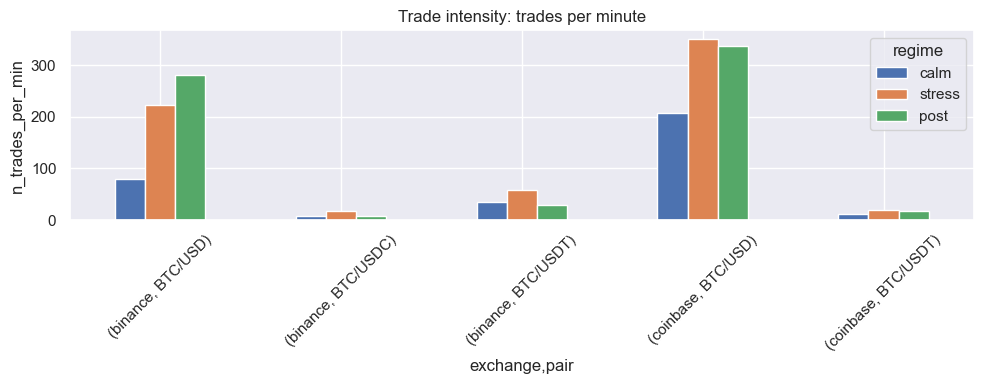

In [177]:
plot_metric(all_summary, 'depth_proxy_vol_over_rv', 'Depth proxy: dollar volume / mean RV (higher = deeper)')
plot_metric(all_summary, 'inv_amihud_median', 'Inverse Amihud (higher = deeper)')
plot_metric(all_summary, 'kyle_lambda_scaled', 'Kyles Lambda (lower = deeper)')
plot_metric(all_summary, 'n_trades_per_min', 'Trade intensity: trades per minute')

## Spread Proxies
- On Binance, spreads are systematically tighter for USD, wider for USDT, and widest for USDC (especially in stress).
- On Coinbase, spread evidence is incomplete at 10s; you can either tune freq (try 5s and 30s) or present Roll only where identified

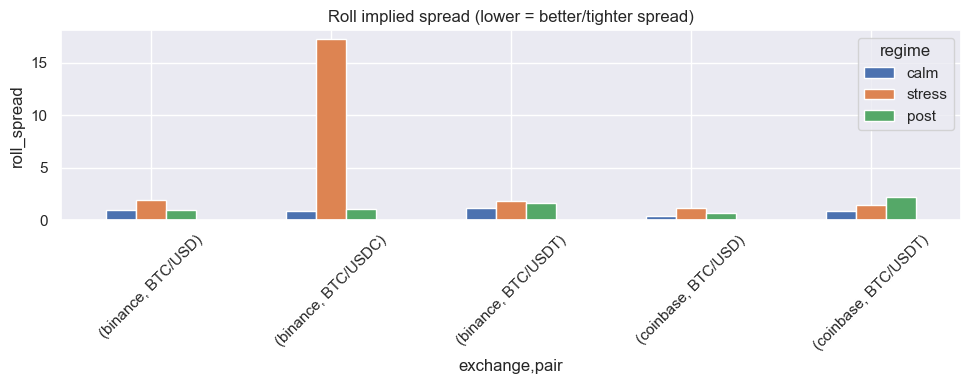

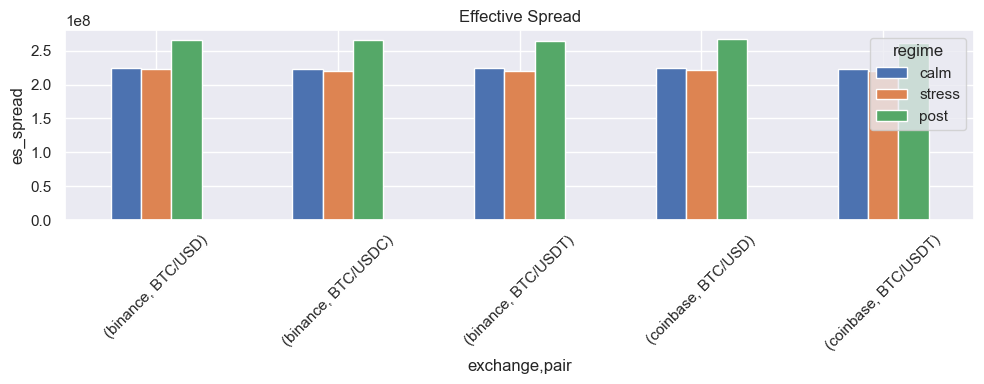

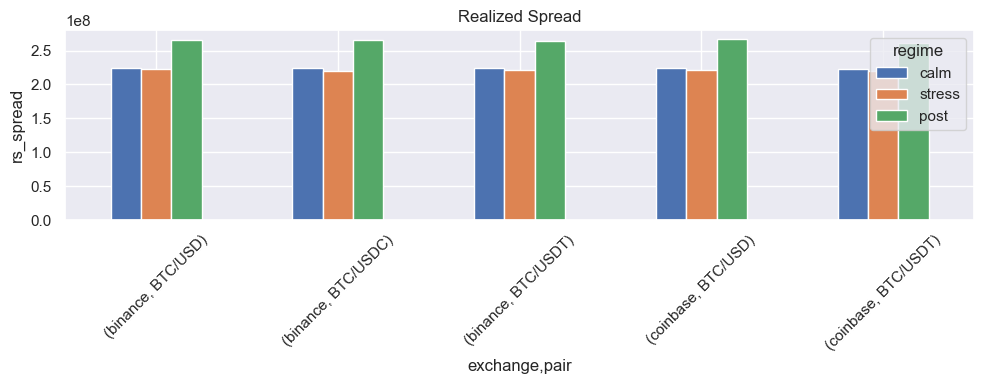

In [184]:
plot_metric(all_summary, "roll_spread", "Roll implied spread (lower = better/tighter spread)")
plot_metric(all_summary, "es_spread", "Effective Spread")
plot_metric(all_summary, "rs_spread", "Realized Spread")